## Doubly Robust Estimator

Usually both linear regression and propensity score matching will be somewhat wrong. Hence, as the name might suggest, the Doubly Robust Estimator combines them in a way it is not necessary to rely on either of the models.

Under these circumstances, the only requirement is that **at least one of the models is correctly specified**. If one of them is really wrong or random, then the natural consequence is that variance will be higher, but the estimate will still be more reliable.

### Mathematically Combining the Models

$\hat{ATE} = \frac{1}{N} \sum{[\frac{T_{i}(Y_{i} - \hat{\mu_{1}(X_{i})})}{\hat{P(X_{i})}} + \hat{\mu_{1}(X_{i})}}] - \frac{1}{N} \sum{[\frac{(1-T_{i})(Y_{i} - \hat{\mu_{0}(X_{i})})}{1-\hat{P(X_{i})}} + \hat{\mu_{0}(X_{i})}}]$

Notation:

* $\hat{P(X_{i})}$ is an estimation of the propensity score
* $\hat{\mu_{1}(X_{i})}$ is an estimation of $\mathbb{E}[Y|X,T=1]$
* $\hat{\mu_{0}(X_{i})}$ is an estimation of $\mathbb{E}[Y|X,T=0]$

### Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns
style.use("fivethirtyeight")

import warnings
warnings.filterwarnings("ignore")

### Data

For the sake of simplicity and learning, we are going to use a dataset to answer the following causal question: *Is smoking associated with psychological distress?*.

In this case, `smoker` is our treatment variable, while `psyc_distress` is our outcome variable. The main idea is that we will match smokers and non-smokers according to a set of covariates, including `sex` (0: Female; 1: Male), `indigeneity` (0: Non-indigenous; 1: indigenous), `high_school` (0: not finished high school; 1: finished high school), `partnered` (0: not partnered; 1: partnered), `remoteness` (0: major cities; 1: inner regional; 2: outer regional), `language` (0: non-English speaking; 1: English speaking), `age` and `risky_alcohol` (alcohol use - 0: not risky; 1: risky).

In [2]:
df = pd.read_csv("../data/smoking_psyc_distress.csv",)
df.head()

,sex,indigeneity,high_school,partnered,remoteness,language,smoker,risky_alcohol,psyc_distress,age
0,0,0,1,1,0,1,0,0,13,63
1,0,0,1,1,0,1,0,1,11,48
2,0,0,0,0,0,1,0,1,11,54
3,1,0,1,1,0,1,0,1,12,50
4,0,0,0,1,1,1,0,1,10,67


Some basic definitions:

In [3]:
Y = "psyc_distress"
T = "smoker"
X = [c for c in df.columns if not c in [Y, T]]

From the visualizations below, we can see that men, high-school dropouts and indigenous people tend to smoke more. Initially, it seems that these groups also present higher psychological distress. However, for women, it seems that it is quite the opposite, since they have slightely higher distress.

This is a perfect scenario for us to apply matching techniques, once we need to make our groups comparable.

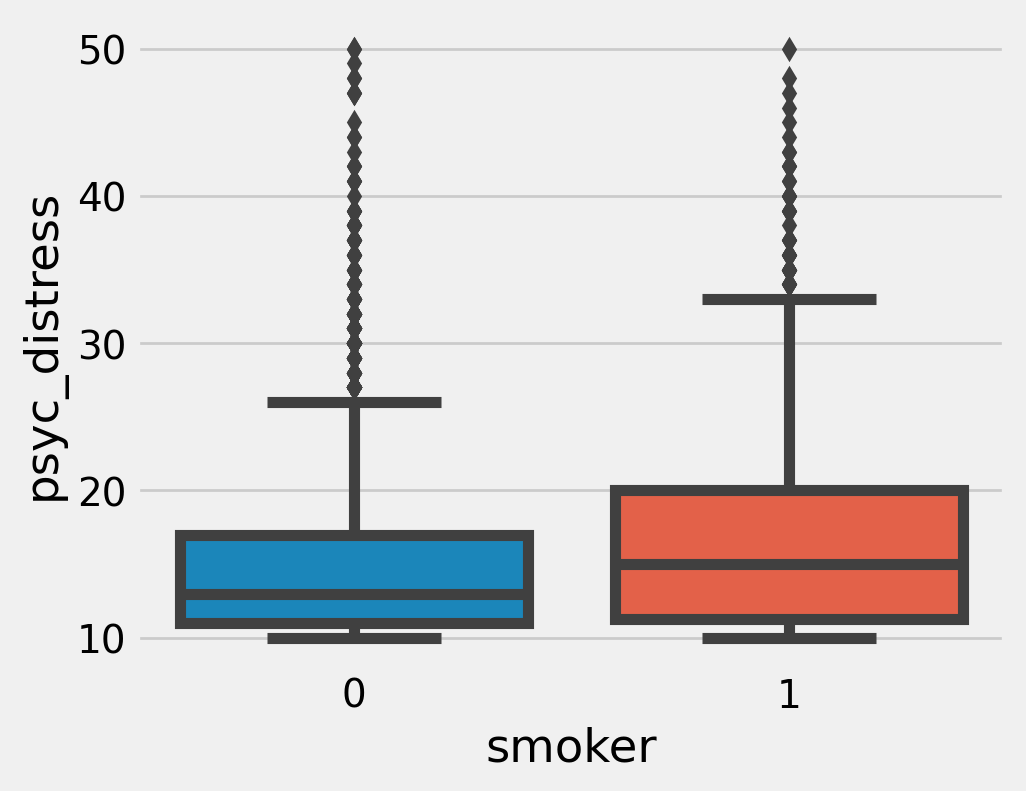

In [4]:
_, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.boxplot(data=df, y=Y, x=T, ax=ax)
plt.show()

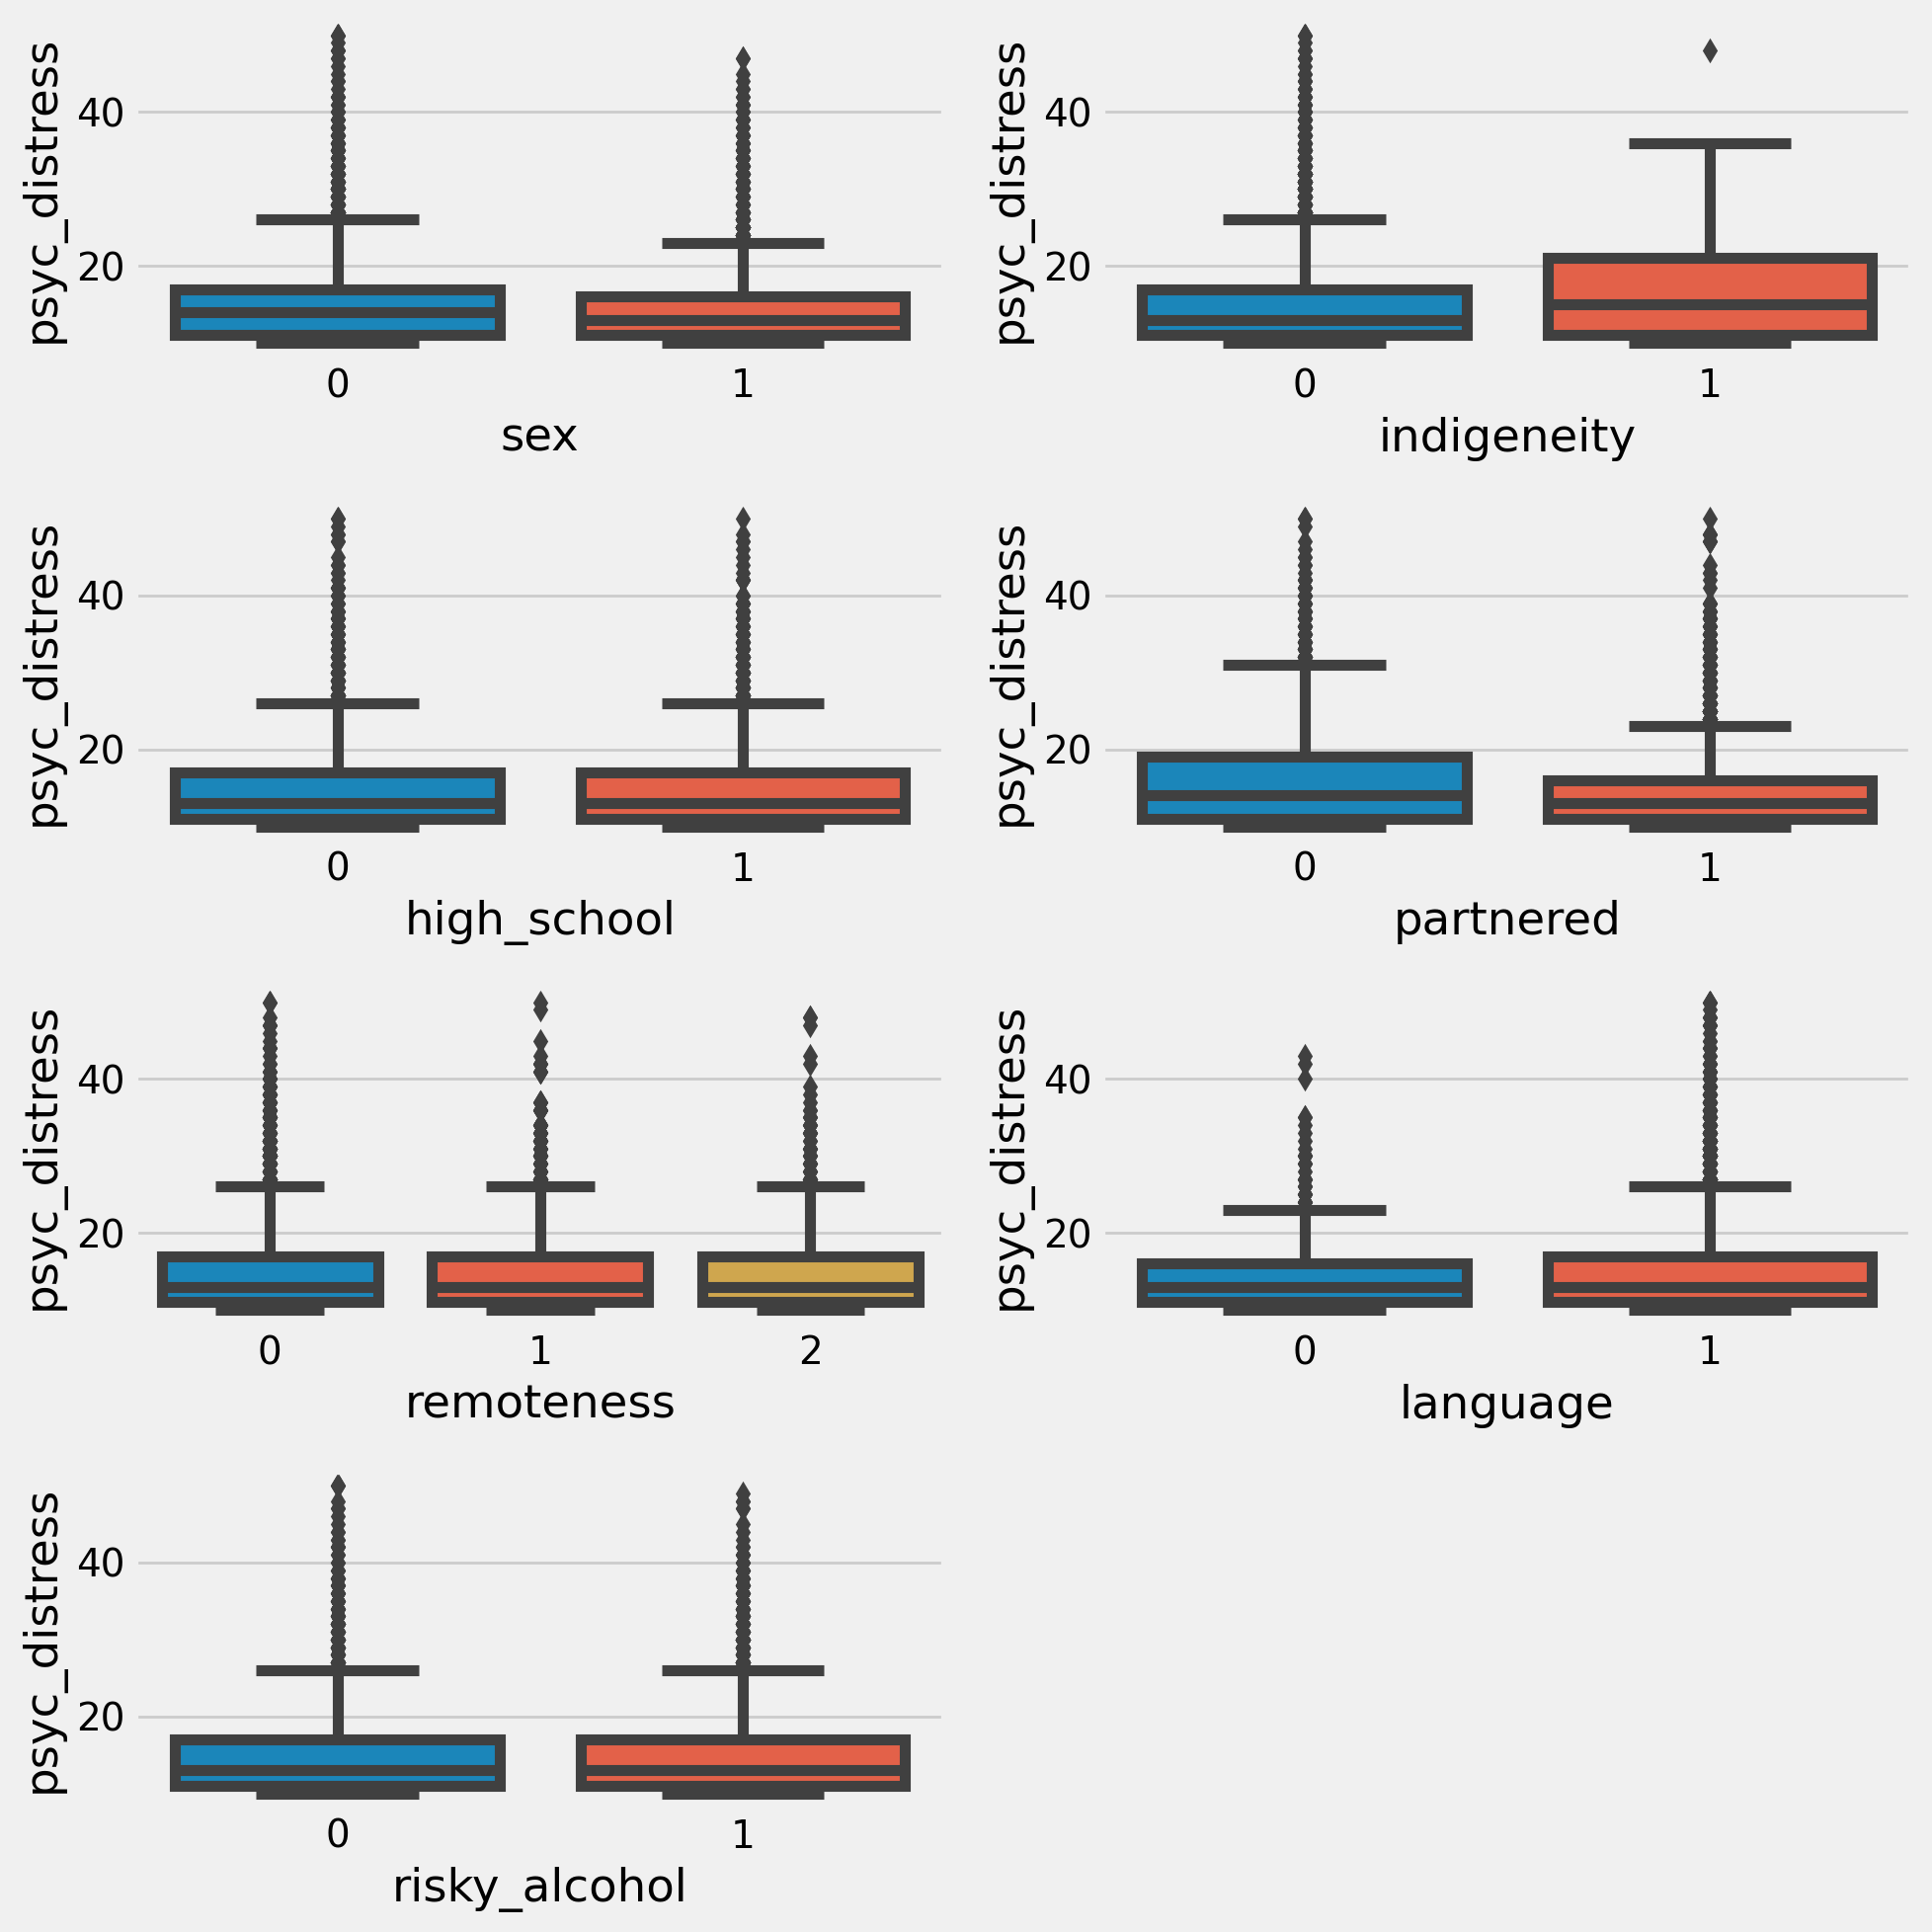

In [5]:
cat_X = [
    c for c in X if c!="age"
]

ncols = 2
nrows = int(np.ceil(len(cat_X) / ncols))

_ = plt.figure(figsize=(10, 10))

for i, x in enumerate(cat_X):
    ax = plt.subplot(nrows, ncols, i+1)
    sns.boxplot(data=df, y=Y, x=x, ax=ax)

plt.tight_layout()
plt.show()

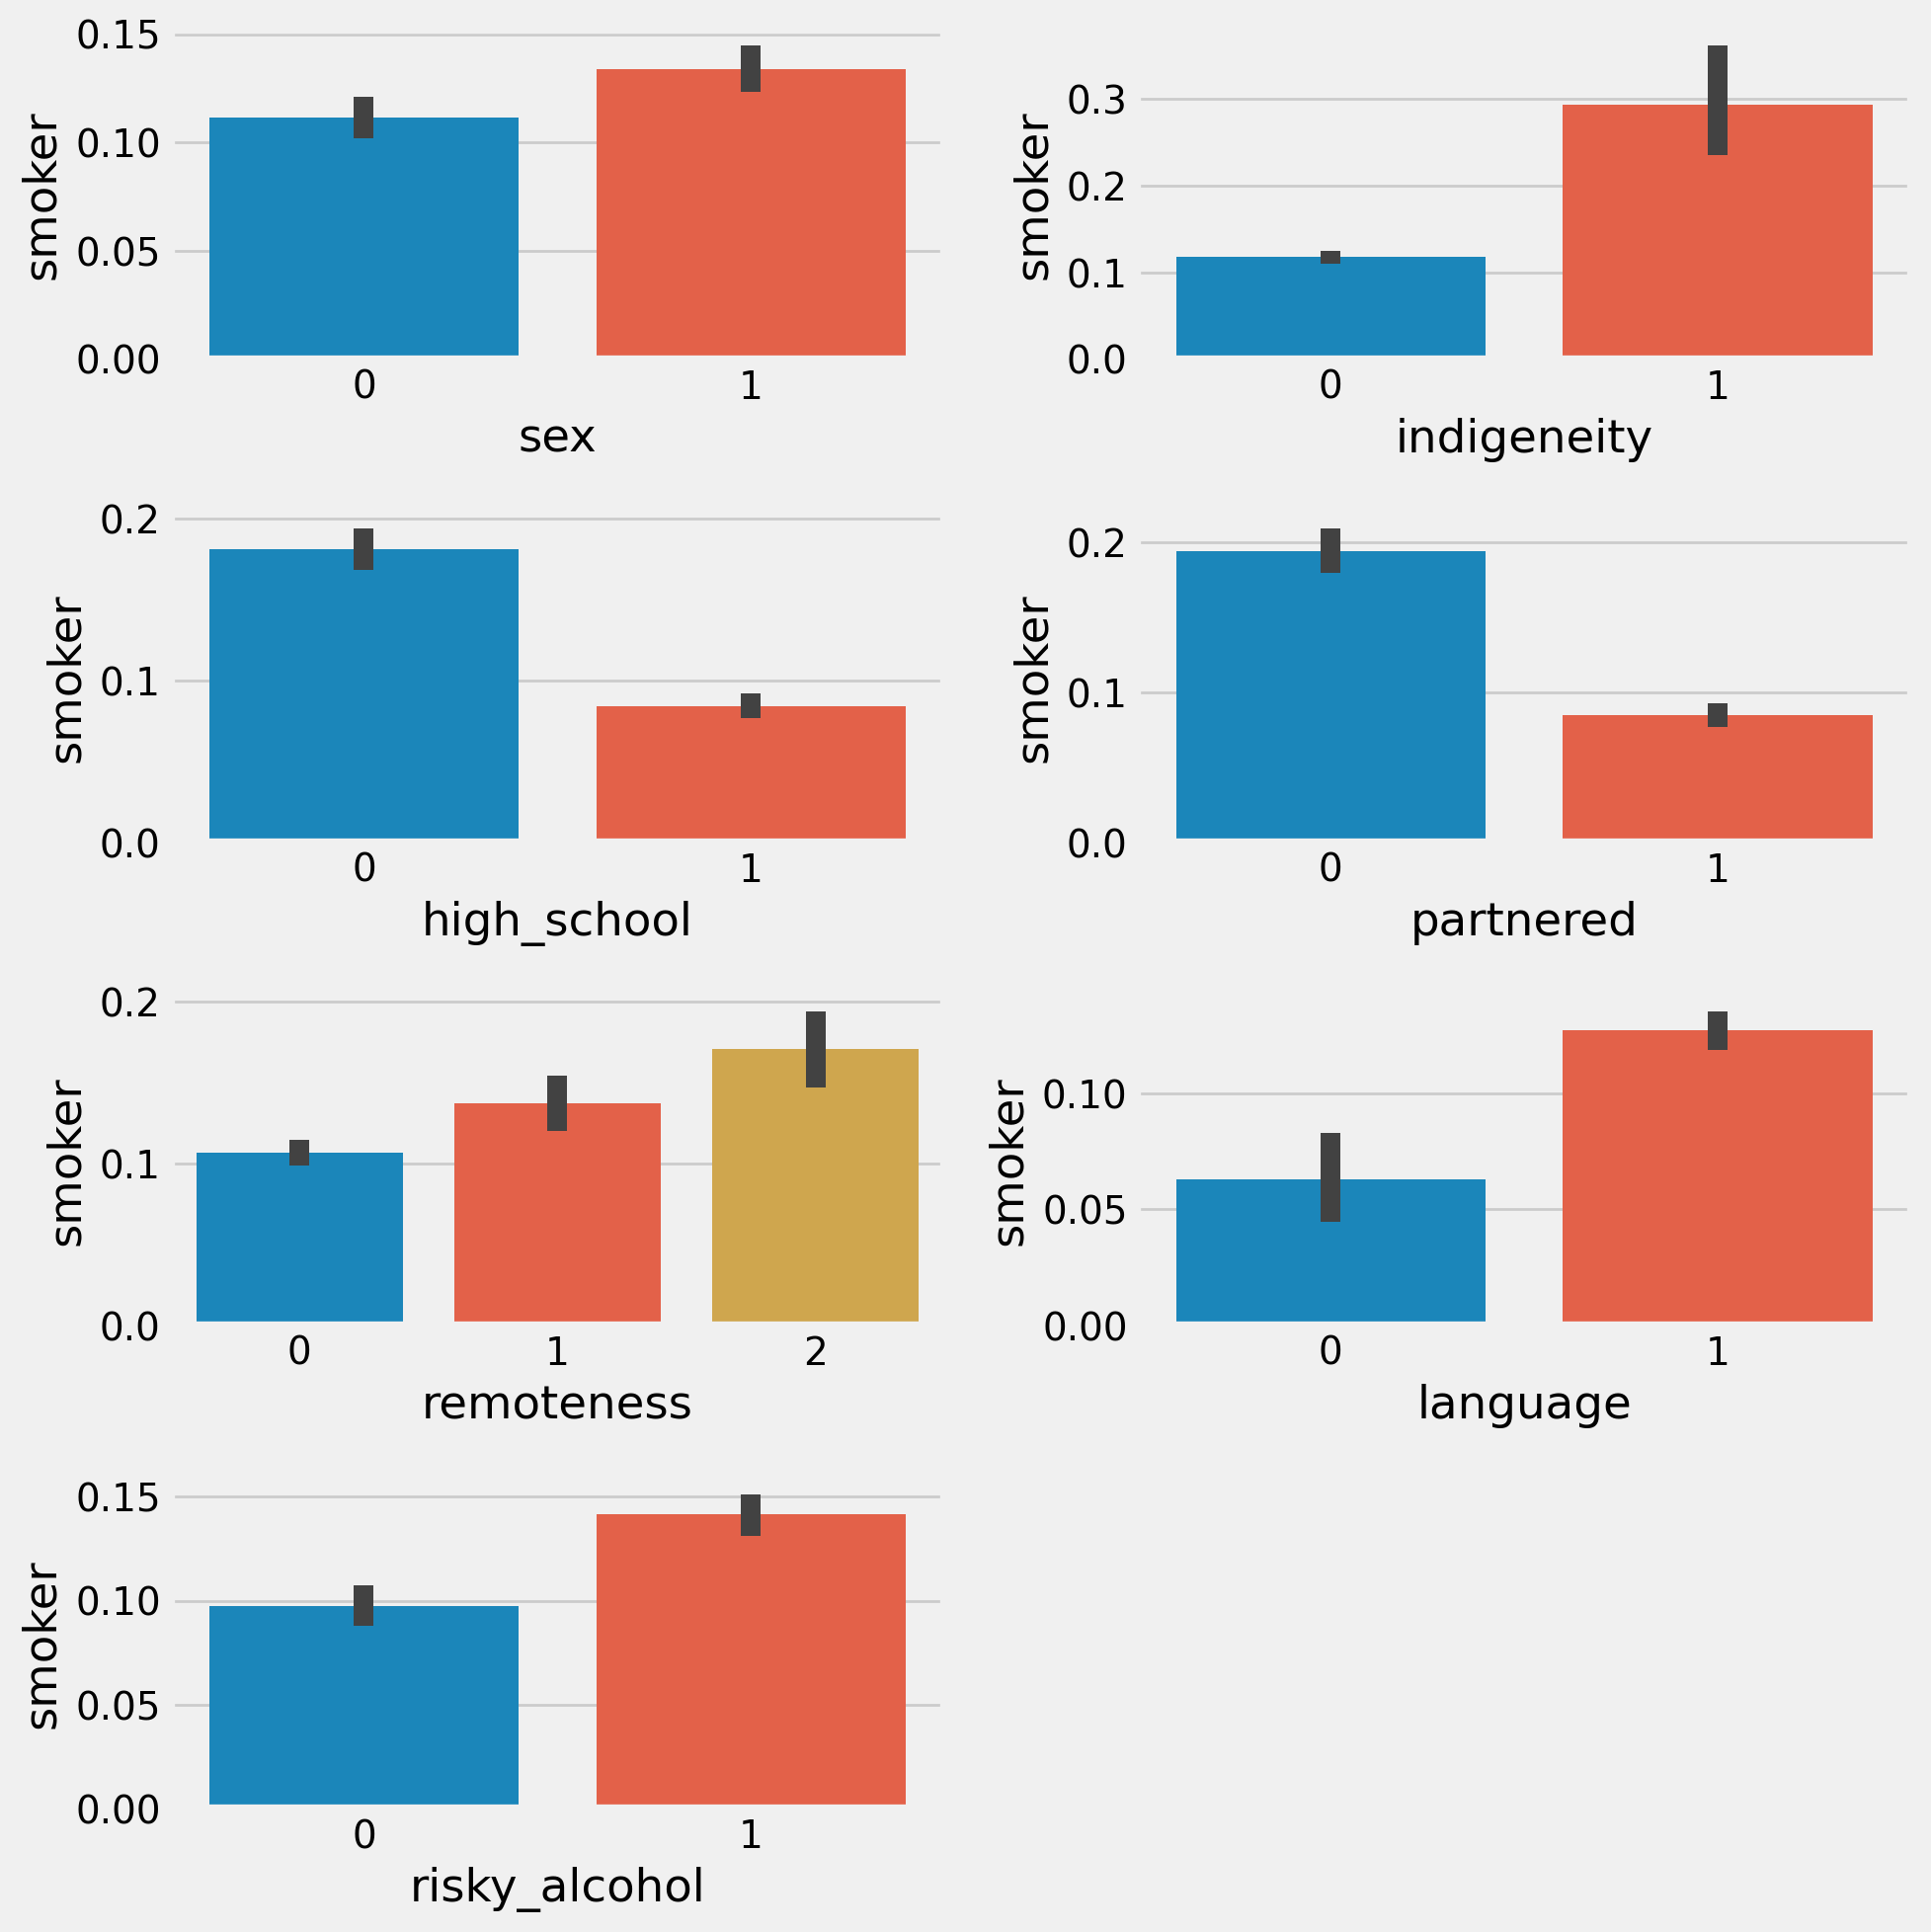

In [6]:
cat_X = [
    c for c in X if c!="age"
]

ncols = 2
nrows = int(np.ceil(len(cat_X) / ncols))

_ = plt.figure(figsize=(10, 10))

for i, x in enumerate(cat_X):
    ax = plt.subplot(nrows, ncols, i+1)
    sns.barplot(data=df, y=T, x=x, ax=ax)

plt.tight_layout()
plt.show()

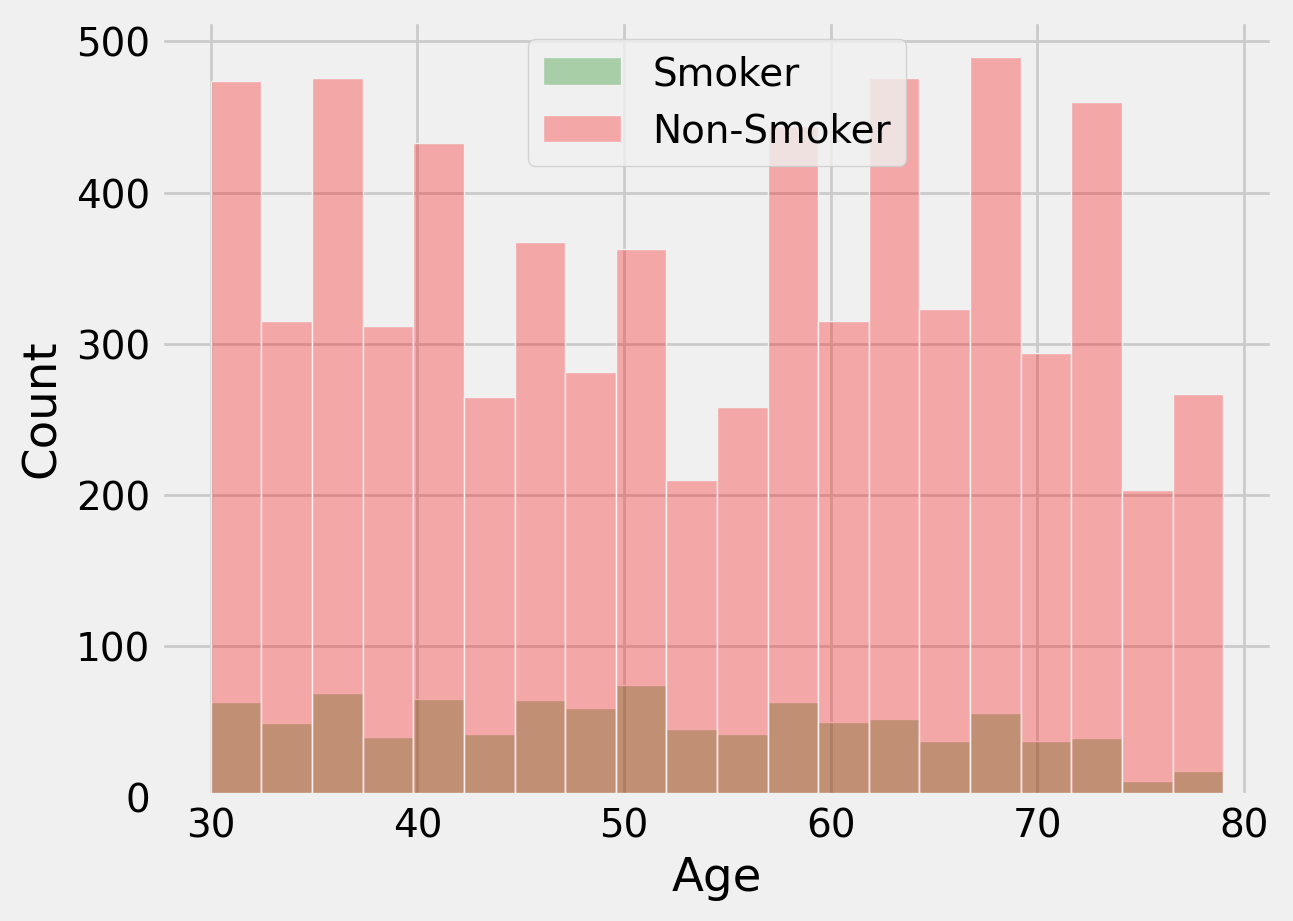

In [7]:
sns.histplot(df.loc[df[T] == 1, "age"], color="green", alpha=0.3, bins=20, label="Smoker", fill=True)
sns.histplot(df.loc[df[T] == 0, "age"], color="red", alpha=0.3, bins=20, label="Non-Smoker", fill=True)
plt.xlabel("Age")
plt.legend()
plt.show()

### Theoretical Approach Step-By-Step

Let's apply what we've seen in the theoretical introduction.

##### Logistic Regression

First, we need to fit our logistic regression model, in order to obtain the propensity scores.

In [8]:
lr = Pipeline(steps=[
    ("preprocessing", ColumnTransformer(transformers=[
        ("scale", StandardScaler(), ["age"]),
        ("ohe", OneHotEncoder(drop="first", sparse_output=False), ["remoteness"]), 
    ], remainder="passthrough")),
    ("lr", LogisticRegression(C=1e6, random_state=99))
]).fit(df[X], df[T])
ps = lr.predict_proba(df[X])[:, 1]
df = df.assign(ps=ps)

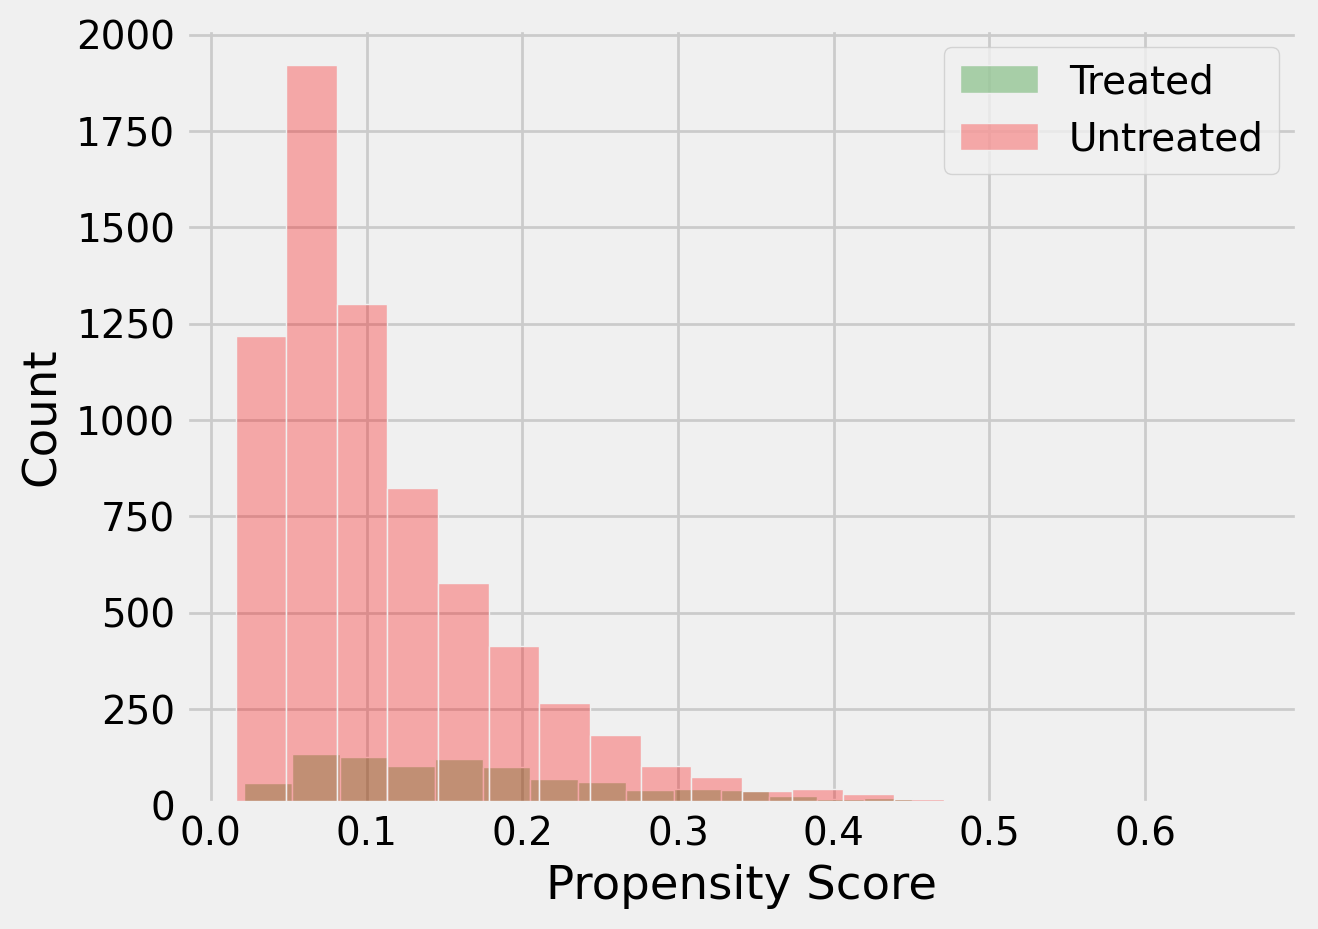

In [9]:
sns.histplot(df.loc[df[T] == 1, "ps"], color="green", alpha=0.3, bins=20, label="Treated", fill=True)
sns.histplot(df.loc[df[T] == 0, "ps"], color="red", alpha=0.3, bins=20, label="Untreated", fill=True)
plt.xlabel("Propensity Score")
plt.legend()
plt.show()

##### Linear Regression

Finally, let's compute the estimates according to the linear regression model.

In [10]:
mu0 = Pipeline(steps=[
    ("preprocessing", ColumnTransformer(transformers=[
        ("scale", StandardScaler(), ["age"]),
        ("ohe", OneHotEncoder(drop="first", sparse_output=False), ["remoteness"]), 
    ], remainder="passthrough")),
    ("lr", LinearRegression())
]).fit(
    df.query(f"{T} == 0")[X],
    df.query(f"{T} == 0")[Y]
).predict(df[X])

mu1 = Pipeline(steps=[
    ("preprocessing", ColumnTransformer(transformers=[
        ("scale", StandardScaler(), ["age"]),
        ("ohe", OneHotEncoder(drop="first", sparse_output=False), ["remoteness"]), 
    ], remainder="passthrough")),
    ("lr", LinearRegression())
]).fit(
    df.query(f"{T} == 1")[X],
    df.query(f"{T} == 1")[Y]
).predict(df[X])

##### Estimating ATE

Given that there is an actual overlap between both distributions, let's check results.

In [11]:
ate = np.mean(
    df[T] * (df[Y] - mu1) / df["ps"] + mu1
) - np.mean(
    (1 - df[T]) * (df[Y] - mu0) / (1 - df["ps"]) + mu0
)
print(f"ATE = {ate:.2f}")

ATE = 1.78


This number by itself tells us nothing, we need an actual confidence interval. You might have realized that this is a tedious job to do analytically. Hence, we will once again rely on **Bootstrapping** to do the job.

In [12]:
from joblib import Parallel, delayed

In [13]:
def estimate_ate_with_doubly_robust_estimator(
    df, Y, T, X
):
    # Propensity Score Matching
    ps = Pipeline(steps=[
        ("preprocessing", ColumnTransformer(transformers=[
            ("scale", StandardScaler(), ["age"]),
            ("ohe", OneHotEncoder(drop="first", sparse_output=False), ["remoteness"]), 
        ], remainder="passthrough")),
        ("lr", LogisticRegression(C=1e6, random_state=99))
    ]).fit(
        df[X], df[T]
    ).predict_proba(df[X])[:, 1]

    # Linear Regression
    mu0 = Pipeline(steps=[
        ("preprocessing", ColumnTransformer(transformers=[
            ("scale", StandardScaler(), ["age"]),
            ("ohe", OneHotEncoder(drop="first", sparse_output=False), ["remoteness"]), 
        ], remainder="passthrough")),
        ("lr", LinearRegression())
    ]).fit(
        df.query(f"{T} == 0")[X],
        df.query(f"{T} == 0")[Y]
    ).predict(df[X])

    mu1 = Pipeline(steps=[
        ("preprocessing", ColumnTransformer(transformers=[
            ("scale", StandardScaler(), ["age"]),
            ("ohe", OneHotEncoder(drop="first", sparse_output=False), ["remoteness"]), 
        ], remainder="passthrough")),
        ("lr", LinearRegression())
    ]).fit(
        df.query(f"{T} == 1")[X],
        df.query(f"{T} == 1")[Y]
    ).predict(df[X])

    return (
        np.mean(
            df[T] * (df[Y] - mu1) / ps + mu1
        ) - 
        np.mean(
            (1 - df[T]) * (df[Y] - mu0) / (1 - ps) + mu0
        )
    )

In [14]:
np.random.seed(99)

ates = Parallel(n_jobs=2)(
    delayed(estimate_ate_with_doubly_robust_estimator)(df.sample(frac=1, replace=True), Y, T, X)
    for _ in range(1_000)
)

In [15]:
lower = np.quantile(ates, 0.025)
upper = np.quantile(ates, 0.975)

print(f"({lower:.2f}, {upper:.2f})")

(1.28, 2.28)


### Our approach

In [16]:
# from causal_inference.linear import DoublyRobustEstimator

In [17]:
# m = DoublyRobustEstimator(
#     data=df,
#     outcome=Y,
#     treatment=T,
#     numerical_covariates=["age"],
#     categorical_covariates=[c for c in X if c!="age"],
#     logistic_regression_regularization=1e6,
# )
# m.fit(check_distributions=True)

In [18]:
# m.estimate_ate(plot_result=True)